# Alternative Splicing in MD

In [4]:
from transvis.io import *
from transvis.alterSplice import *
from transvis.utils import *
initDB()

In [9]:
# you can set this up to 2**64 if you want everything processed, or less for debugging.
processedNo = 2**64

In [10]:
from intervaltree import Interval, IntervalTree
intervaltrees = {}


# We're going to iterate through all probesets, and retrive from the annotation metadata corresponding to each probeset the probeset location, expressed in genomic coordinates with GRCh37 as the reference genome.

## Takes about 5 minutes

In [10]:
currentIter = transIter()

allchr = set()

# ml := metadataLookup
ml = {key : value for key, value in zip(metadataKeys(), range(len(metadataKeys())))}
for _, transID in zip(range(processedNo), currentIter):
    probesets = transToProbeset(transID)
    for probeset in probesets:
        metadata = probesetAnnotationMetadata(probeset)
        seqname = metadata[ml['seqname']]
        strand = metadata[ml['strand']]
        seqname += strand
        if re.findall("^chr*", seqname):
            allchr.add(seqname)
            if seqname not in intervaltrees:
                t = IntervalTree()
                intervaltrees[seqname] = t
            else:
                t = intervaltrees[seqname]
            start = metadata[ml['start']]
            stop = metadata[ml['stop']]
            try:
                start = int(start)
                stop = int(stop)
            except ValueError:
                continue
            if start == 0 or stop == 0:
                continue
            t[start:stop] = probeset

# Then, we'll iterate through all genecode transcripts, and use the Binary Interval Tree, to find those probesets, which are strictly contained within exons belonging to these transcripts.

## Takes another 5 minutes

In [59]:
for c in allchr:
    c = c[:-1]
    for genecodeI, genecode in zip(range(processedNo), genecodeIter(c)):
        for transcriptI, transcript in enumerate(genecode):
            typ = transcript[0]
            chromosome = transcript[1]
            suffix = transcript[2]
            seqname = chromosome + suffix
            if typ == "exon":
                key = transcript[-1]
                start = int(transcript[3])
                stop = int(transcript[4])
                setGenecodeGenenameBoundary(key, chromosome, suffix, start, stop)
                result = intervaltrees[seqname].search(start, stop, strict=True)
                if result:
                    for interval in result:
                        probeset = interval.data
                        setGenecodeGenenameToProbeset(key, probeset)


# For example all MBNL1's exons strictly contain the following probesets.

In [11]:
getGenecodeGenenameToProbeset("MBNL1")

{b'2648142',
 b'2648143',
 b'2648146',
 b'2648147',
 b'2648158',
 b'2648159',
 b'2648160',
 b'2648161',
 b'2648167',
 b'2648174',
 b'2648175',
 b'2648178',
 b'2648180',
 b'2648181',
 b'2648184',
 b'2648185',
 b'2648186',
 b'2648194',
 b'2648197',
 b'2648199',
 b'2648200',
 b'2648201',
 b'2648202',
 b'2648203',
 b'2648204',
 b'2648205'}

# For the visualisation tool we also record the genomic coordinates of each gene


In [9]:
getGenecodeGenenameBoundary("MBNL1")

[151961617, 152183569, 'chr3', '+']

In [10]:
genecodeHGNC = set(d(i).split("$")[-1] for i in redisConn["genecode"].keys("genename$probeset$*"))

In [11]:
properHGNC = set()

In [12]:
with open("CEL_files/HGNC_names.txt") as f:
    for line in f:
        properHGNC.add(line.strip())

# The file HGNC_names.txt contains all legal HGNC names, as per the HGNC website. As one can see, there are 40938 genes in total in this reference database

In [13]:
len(properHGNC)

40938

# Our method of using genecode identifies over 43 thousand genes.

In [14]:
len(genecodeHGNC)

43705

# Let us narrow down to the genes at the intersection of these gene lists.

In [15]:
genesToInvest = properHGNC.intersection(genecodeHGNC)

In [16]:
len(genesToInvest)

28898

In [17]:
distribution = [len(getGenecodeGenenameToProbeset(i)) for i in genesToInvest]

In [18]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [19]:
len([i for i in distribution if i > 400])

1

In [20]:
for i in genesToInvest:
    probesets = getGenecodeGenenameToProbeset(i)
    if len(probesets) > 400:
        print(i)

TTN


# That for example is a histogram of probesets/gene. The gene with the highest number of probesets is titin (which is actually a very interesting gene/protein)

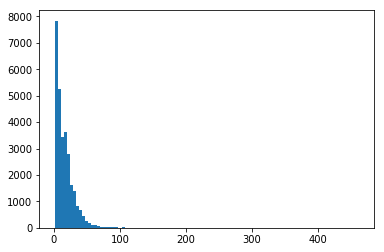

In [21]:
ax1 = plt.subplot()
ax1.hist(distribution, bins=100)
_ = _

In [22]:
# We can zoom in to discover how many genes have outragesouly few probes (I suggest we resign from all genes with < 4 probes).

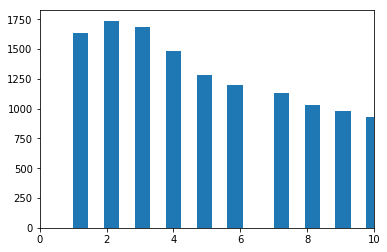

In [23]:
ax1 = plt.subplot()
ax1.hist(distribution, bins=1000)
ax1.set_xlim([0, 10])
_ = _

# Just to be sure, let's check how large are the "windows" we're going to look at our genes through

In [24]:
windows = [(gene, getGenecodeGenenameBoundary(gene)) for gene in genesToInvest]

In [25]:
windowsSize = [(stop - start, start, stop, gene, chromosome, strand) for gene, (start, stop, chromosome, strand) in windows]

In [26]:
windowsSize.sort()

# Then, let's check if there are any genes, which were incorrectly assigened very large windows.

In [27]:
windowsSize[-20:]

[(1697917, 78636716, 80334633, 'NRXN3', 'chr14', '+'),
 (1743269, 75955846, 77699115, 'ROBO2', 'chr3', '+'),
 (1783651, 67672276, 69455927, 'CTNNA3', 'chr10', '-'),
 (1825171, 55562531, 57387702, 'PCDH15', 'chr10', '-'),
 (1900278, 140988992, 142889270, 'LRP1B', 'chr2', '-'),
 (1987242, 64429876, 66417118, 'EYS', 'chr6', '-'),
 (2057827, 13976015, 16033842, 'MACROD2', 'chr20', '+'),
 (2059619, 2792875, 4852494, 'CSMD1', 'chr8', '-'),
 (2172911, 83166055, 85338966, 'DLG2', 'chr11', '-'),
 (2241764, 31115794, 33357558, 'DMD', 'chrX', '-'),
 (2298477, 8314246, 10612723, 'PTPRD', 'chr9', '-'),
 (2304996, 145813094, 148118090, 'CNTNAP2', 'chr7', '+'),
 (24961288, 29558488, 54519776, 'LINC01598', 'chr12', '-'),
 (95897243, 59208305, 155105548, 'DPH3P2', 'chrX', '+'),
 (95897327, 59311663, 155208990, 'ELOCP24', 'chrX', '-'),
 (95897873, 59318041, 155215914, 'TRPC6P', 'chrX', '-'),
 (95901878, 59353497, 155255375, 'WASH6P', 'chrX', '+'),
 (95910230, 59330252, 155240482, 'IL9R', 'chrX', '+'),
 

# Some reading suggests that everything larger than CNTNAP2 is due to errors in our annotation methodology or genecode and should not be included.

In [28]:
maxWindowSizeThreshold = 5000000

In [29]:
minProbesetSize = 4

In [30]:
cleanedUpGenes = []

In [31]:
for gene in genesToInvest:
    start, stop, chromosome, strand = getGenecodeGenenameBoundary(gene)
    if stop - start > maxWindowSizeThreshold:
        continue
    if len(getGenecodeGenenameToProbeset(gene)) < minProbesetSize:
        continue
    cleanedUpGenes.append(gene)

# This leaves us with 23827 genes to look at

In [32]:
len(cleanedUpGenes)

23827

In [62]:
def pValueForProbeset(probeData):
    left_pvalues = []
    right_pvalues = []
    ma = modalAllele()
    for seq, data in probeData.items():
        assert(len(ma) == len(data))
        regressR = linregress(ma, data)
        left_pvalues.append(regressR.leftpvalue)
        right_pvalues.append(regressR.rightpvalue)
    leftresult = productCDF(product(left_pvalues), len(left_pvalues))
    rightresult = productCDF(product(right_pvalues), len(right_pvalues))
    return min(leftresult, rightresult) * 2

In [63]:
def computeGenePValue(probesets, modalAllele):
    if not probesets:
        raise ValueError("probesets can't be empty")
    corrections = []
    for i, probeset in enumerate(probesets):
        data, probemetadata = dataForProbeset(probeset)
        for seq, intensities in data.items():
            allProbeData.append(intensities)
    allProbeData = np.array(allProbeData)
    for j in range(allProbeData.shape[1]):
        corrections.append(sum(allProbeData[:, j])/allProbeData.shape[0])
    result = []
    for i, probeset in enumerate(probesets):
        data, probemetadata = dataForProbeset(probeset)
        newData = {}
        for seq, intensities in data.items():
            newIntensities = [datum - correction for datum, correction in zip(intensities, corrections)]
            newData[seq] = newIntensities
        result.append((pValueForProbeset(customMA, newData), probeset))
    result.sort()
    return result

In [73]:
for gene in cleanedUpGenes:
    probesets = getGenecodeGenenameToProbeset(gene)
    allPatientsGenes = [[] for _ in modalAllele()]
    patientCorrections = []
    for probeset in probesets:
        for patientNo, probesetData in enumerate(probesetPatientData(probeset)):
            for probeD in probesetData:
                allPatientsGenes[patientNo].append(probeD)
    
    for patientD in allPatientsGenes:
        patientCorrections.append(sum(patientD)/len(patientD))
    for probeset in probesets:
        print(pValueForProbeset(dataForProbeset(str(probesetAnnotationMetadata(probeset)[0]))["probeData"]))
    #print(patientCorrections)
    break

0.321878220837
0.111405823311
0.234487327438
0.0133989654802
0.685116997593
